In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.optim as optim
from tqdm import tqdm

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(0.3, 0.5, 0.5),
    transforms.ToTensor(),
])

In [38]:
dataset = datasets.ImageFolder(root="../Data", transform=transform)

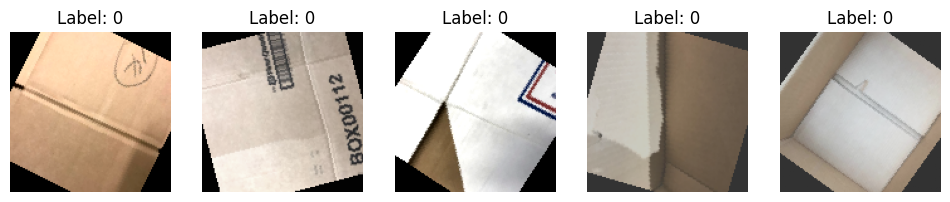

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    image, label = dataset[i]
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

In [40]:
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [41]:
batchsize = 64

In [42]:
datasetLen = len(dataset)
train_ratio = 0.9
test_ratio = 0.1
train_size = int(train_ratio * datasetLen)
test_size = datasetLen - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [43]:
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False, pin_memory=True)


In [44]:
example_train_data = iter(train_loader)
example = next(example_train_data)
print(example)

[tensor([[[[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431]],

         [[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431]],

         [[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0431, 0.0431,  ..., 

In [45]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout_fc = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [46]:
print("HI")
for epoch in range(10):
    print("HI")
    index = 0
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    for images, labels in loop:
        print("HI")
        index+=1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/10]")
        loop.set_postfix(loss=loss.item())
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
    print("HO")

HI
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [1/10]:   3%|▎         | 1/36 [00:26<15:42, 26.92s/it, loss=1.84]

HI


Epoch [1/10]:   6%|▌         | 2/36 [00:34<08:43, 15.40s/it, loss=2.46]

HI


Epoch [1/10]:   8%|▊         | 3/36 [00:40<06:06, 11.09s/it, loss=1.84]

HI


Epoch [1/10]:  11%|█         | 4/36 [00:45<04:39,  8.72s/it, loss=1.73]

HI


Epoch [1/10]:  14%|█▍        | 5/36 [00:50<03:50,  7.43s/it, loss=1.75]

HI


Epoch [1/10]:  17%|█▋        | 6/36 [00:56<03:29,  6.97s/it, loss=1.73]

HI


Epoch [1/10]:  19%|█▉        | 7/36 [01:01<03:07,  6.45s/it, loss=1.78]

HI


Epoch [1/10]:  22%|██▏       | 8/36 [01:06<02:46,  5.96s/it, loss=1.57]

HI


Epoch [1/10]:  25%|██▌       | 9/36 [01:11<02:30,  5.56s/it, loss=1.66]

HI


Epoch [1/10]:  28%|██▊       | 10/36 [01:16<02:17,  5.28s/it, loss=1.73]

HI


Epoch [1/10]:  31%|███       | 11/36 [01:20<02:06,  5.06s/it, loss=1.65]

HI


Epoch [1/10]:  33%|███▎      | 12/36 [01:25<01:58,  4.95s/it, loss=1.62]

HI


Epoch [1/10]:  36%|███▌      | 13/36 [01:30<01:54,  4.96s/it, loss=1.57]

HI


Epoch [1/10]:  39%|███▉      | 14/36 [01:36<01:53,  5.17s/it, loss=1.52]

HI


Epoch [1/10]:  42%|████▏     | 15/36 [01:41<01:49,  5.21s/it, loss=1.65]

HI


In [ ]:
model.eval()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
all_preds = []
all_labels = []

In [ ]:
testing_criterion = torch.nn.CrossEntropyLoss()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

In [ ]:
test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
torch.save(model.state_dict(), "cnn_model.pth")

In [ ]:
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

In [ ]:
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()